# Building an Anime Recommender System

In [2]:
import datasets, utils
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Load Dataset

In [3]:
data = datasets.MyAnimeList(debug=True)
data.X = data.X.tocsc()

0it [00:00, ?it/s]


### 2. Build Prediction

Current best time on debug set (k=7):

* Iteration 0 : 24.73 seconds
* Iteration 1 : 48.98 seconds

Iteration  0 :  Training Error = 10.1485  Time = 14.73
Iteration  1 :  Training Error = 1.7408  Time = 48.98
Iteration  2 :  Training Error = 1.5118  Time = 48.66
Iteration  3 :  Training Error = 1.4126  Time = 47.44
Iteration  4 :  Training Error = 1.3745  Time = 48.05
Iteration  5 :  Training Error = 1.3562  Time = 48.47
Iteration  6 :  Training Error = 1.3458  Time = 47.29
Iteration  7 :  Training Error = 1.3390  Time = 49.75
Iteration  8 :  Training Error = 1.3343  Time = 50.58
Iteration  9 :  Training Error = 1.3309  Time = 47.67
Iteration 10 :  Training Error = 1.3286  Time = 48.92


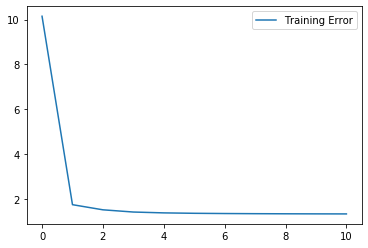

In [4]:
import importlib
importlib.reload(utils)
nfeatures = 7
steps = 10
model = utils.MatrixFactorization(k=nfeatures, reg=20.)
model.fit(data.X,steps=10)

In [6]:
for k in range(nfeatures):
    jmax = model.V[:,k].argmax()
    jmin = model.V[:,k].argmin()
    idmax = data.cindex[jmax]
    idmin = data.cindex[jmin]
    amax = data.get_anime_by_id(idmax)
    amin = data.get_anime_by_id(idmin)
    str_ = (
        f'Feature {k+1}:\n'
        f'\tmax : ({model.V[jmax,k]:+2.1f}) {amax.title}\n'
        f'\tmin : ({model.V[jmin,k]:+2.1f}) {amin.title}'
    )
    print(str_)

Feature 1:
	max : (+1.5) Diabolik Lovers
	min : (-1.4) Neon Genesis Evangelion: The End of Evangelion
Feature 2:
	max : (+1.3) Lucky☆Star
	min : (-1.4) Naruto: Shippuuden
Feature 3:
	max : (+2.6) School Days
	min : (-1.0) Papa to Kiss in the Dark
Feature 4:
	max : (+2.2) Naruto: Shippuuden
	min : (-0.9) The Sky Crawlers
Feature 5:
	max : (+0.9) Clannad: After Story
	min : (-2.3) Boku no Pico
Feature 6:
	max : (+1.3) Bishoujo Senshi Sailor Moon
	min : (-1.5) Sword Art Online
Feature 7:
	max : (+1.4) Vampire Knight: Guilty
	min : (-0.9) FLCL


### ToDo
* Predict scores of users not in dataset.
* REST Api: https://medium.com/@mahdi04/train-predict-simple-machine-learning-models-with-django-rest-76ce46bf2868

### 3. Webscrape current animelist

In [ ]:
pickle_in = open("model.pickle", 'rb')
model = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
myprofile = utils.get_user_anime_list('Manuel')

In [ ]:
index = data.users[data.users.username == 'Manuel'].index

prediction = pd.Series(np.dot(model.U[index],model.V.T).flatten(), index=data.cindex)
prediction = prediction + model.bu[index] + model.mu
watched = [a['id_ref'] for a in myprofile if a['id_ref'] in prediction.index]
prediction = prediction.drop(list(watched))  # Note: columns == anime_ids's

print('Top 10 Anime Predictions')
for i in prediction.sort_values(ascending=False).head(10).index:
    str_ = (
        f"\t({prediction[i]:2.4f}) {data.get_anime_by_id(i).title}"
    )
    print(str_)
    
print('\nBottom 10 Anime Predictions')
for i in prediction.sort_values(ascending=False).tail(10).index:
    str_ = (
        f"\t({prediction[i]:2.4f}) {data.get_anime_by_id(i).title}"
    )
    print(str_)

## PLAYGROUND

In [ ]:
import time

def loss(X, model):
    X = X.tocsc()
    N = 0.
    E = 0.
    for j in range(model.V.shape[0]):
        ivec = X.getcol(j).nonzero()[0]
        xtru = X[ivec,j].todense().T
        xhat = model.U[ivec].dot(model.V[j].T) + model.bu[ivec] + model.bv[j] + model.mu
        resd = xtru - xhat
        E += resd.dot(resd.T)
        N += len(ivec)
    return E[0,0] / N

tstart = time.time()
result = loss(data.X,model)
print(f"Took {time.time()-tstart:.2f} seconds. Result: {result}. Should be {gotcha}.")